In [1]:
from IPython.display import HTML
import time
from torchvision import models
import torch.nn.functional as F
from scipy import linalg
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [4]:
data_folder = "../dataset/CIFAR10data"

In [5]:
print('Downloading data..')
data_raw = datasets.CIFAR10(root=data_folder, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

data_loader = torch.utils.data.DataLoader(data_raw, batch_size=32,
                                         shuffle=True, num_workers=2)

device = torch.device("cuda")

100%|██████████| 170498071/170498071 [00:05<00:00, 29262867.26it/s]


Extracting ../dataset/CIFAR10data/cifar-10-python.tar.gz to ../dataset/CIFAR10data


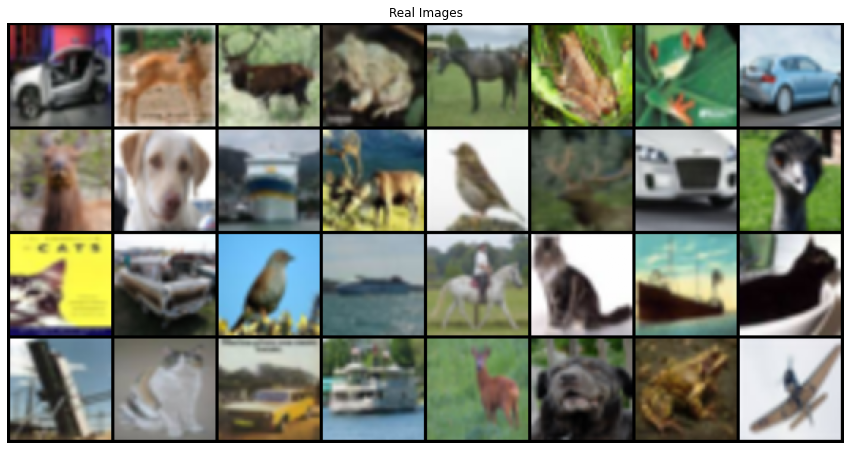

In [6]:
real_image_batch = next(iter(data_loader))
plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Real Images from Data")
plt.imshow(np.transpose(utils.make_grid(real_image_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

<h3> Define the Generator and Discriminator architecture </h3>

#### Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),

            self.Dnet(features_d, features_d * 2, 4, 2, 1),
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

#### Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(

            self.Gnet(channels_noise, features_g * 16, 4, 1, 0),
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

<h3> Initialise model weights </h3>

In [9]:
def initialize_weights(model):
    # Initialised according to DCGAN paper - https://arxiv.org/abs/1511.06434
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [10]:
gen = Generator(channels_noise = 100, channels_img = 3, features_g = 64).to(device)
disc = Discriminator(channels_img = 3, features_d = 64).to(device)
initialize_weights(gen)
initialize_weights(disc)
lr = 2e-4
print('Initialization complete...')

Initiaitalisation done...


In [11]:
optimGenerator = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
optimDiscriminator = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, 100, 1, 1).to(device)
step = 0

#### Model Specs

In [12]:
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [13]:
gen.train()

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, 

<h3> Calculating fretchet distance </h3>

In [14]:
def sqrtm_approx(A, method='ss'):
    if method == 'ss':
        # Scaling and squaring method
        U, s, V = np.linalg.svd(A)
        s = np.diag(np.sqrt(s))
        return U.dot(s).dot(V)
    elif method == 'pi':
        # Power iteration method
        maxiter = 100
        tol = 1e-6
        X = np.eye(A.shape[0])
        for i in range(maxiter):
            Y = 0.5 * (X + A.dot(np.linalg.inv(X)))
            if np.max(np.abs(X - Y)) < tol:
                break
            X = Y
        return X
    else:
        raise ValueError("Invalid method: %s" % method)

#### Inveption network for feature mapping

In [15]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,
        192: 1,
        768: 2,
        2048: 3
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

/home/sarthan/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sarthan/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Activation stats and FID score

In [16]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    
    act=np.empty((len(images), dims))
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariance vectors have different dimensions'

    diff = mu1 - mu2
    
    covmean = sqrtm_approx(sigma1.dot(sigma2), 'ss')

    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps

        offset = np.eye(sigma1.shape[0]) * eps
        covmean = sqrtm_approx((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real
    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1 = calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2 = calculate_activation_statistics(images_fake,model,cuda=True)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [19]:
#training block
generator_loss = []
discriminator_loss = []
fake_images = []
fretchet_distances = []
iters = 0
num_epochs = 50

print("Start training..")

time_start = time.time()

for epoch in range(num_epochs):
    epoch = epoch+1
    for batch_idx, data in enumerate(data_loader,0):

        real = data[0].to(device)
        noise = torch.randn(128, 100, 1, 1).to(device)
        fake = gen(noise)

        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        optimDiscriminator.step()

        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()

        generator_loss.append(loss_gen.detach().cpu())
        discriminator_loss.append(loss_disc.detach().cpu())
        
        
        if (iters % 500 == 0) or ((epoch == num_epochs) and (batch_idx == len(data_loader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            fake_images.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    fretchet_dist = calculate_fretchet(real, fake, model)

    fretchet_distances.append(fretchet_dist)

    if epoch % 5  == 0:
        print(f"Epoch: [{epoch}/{num_epochs}] Batch: {batch_idx}/{len(data_loader)} \
               Discriminator Loss: {loss_disc:.3f}, Generator Loss: {loss_gen:.3f}, Fretchet Distance: {fretchet_dist:.3f} ")

    #Saving Generated image/epoch     
    utils.save_image(fake.detach(),'./dcgan_images/fake/DCGAN_epoch_%03d.png' % (epoch), normalize = True)
    
    #Saving Real image/epoch 
    utils.save_image(real.detach(),'./dcgan_images/real/DCGAN_epoch_%03d.png' % (epoch), normalize = True)
    
time_end = time.time()
print('Total time taken for training：%.2f s.'%(time_end-time_start))

Begining of training..
Epoch: [5/50] Batch: 1562/1563                Discriminator Loss: 0.637, Generator Loss: 0.874, Fretchet Distance: 280.208 
Epoch: [10/50] Batch: 1562/1563                Discriminator Loss: 0.618, Generator Loss: 0.763, Fretchet Distance: 285.877 
Epoch: [15/50] Batch: 1562/1563                Discriminator Loss: 0.405, Generator Loss: 1.674, Fretchet Distance: 266.674 
Epoch: [20/50] Batch: 1562/1563                Discriminator Loss: 0.634, Generator Loss: 1.090, Fretchet Distance: 289.878 
Epoch: [25/50] Batch: 1562/1563                Discriminator Loss: 0.654, Generator Loss: 2.335, Fretchet Distance: 286.165 
Epoch: [30/50] Batch: 1562/1563                Discriminator Loss: 0.343, Generator Loss: 1.749, Fretchet Distance: 267.360 
Epoch: [35/50] Batch: 1562/1563                Discriminator Loss: 0.526, Generator Loss: 2.334, Fretchet Distance: 275.711 
Epoch: [40/50] Batch: 1562/1563                Discriminator Loss: 0.393, Generator Loss: 2.061, Fretch

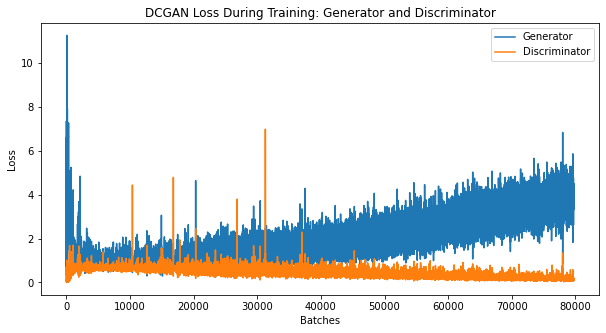

In [20]:
plt.figure(figsize=(10,5))
plt.title("DCGAN Training Loss in Generator and Discriminator")
plt.plot(generator_loss,label="Generator")
plt.plot(discriminator_loss,label="Discriminator")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend()
plt.show()

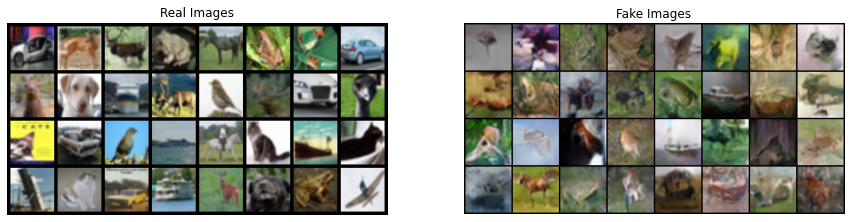

In [21]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_image_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake_images[-1],(1,2,0)))
plt.savefig('./dcgan_images/compare.png')
plt.show()

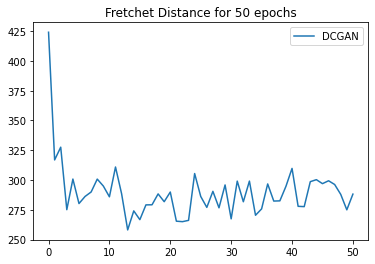

In [23]:
plt.plot(np.arange(0,51), fretchet_distances, label = 'DCGAN')
plt.title('Fretchet Distance for 50 epochs')
plt.legend()
plt.show()

In [24]:
import pickle
with open('./dcgan_images/fd_dcgan.pickle', 'wb') as f:
    pickle.dump(fretchet_distances, f)

In [26]:
import pickle
file = open('wgan_images/fd_wgan.pickle', 'rb')
wgan = pickle.load(file)
dcgan = fretchet_distances

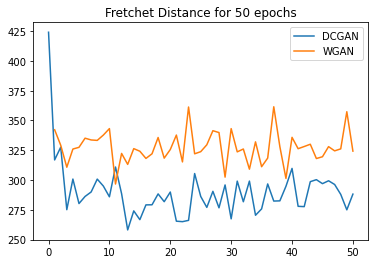

In [29]:
plt.plot(np.arange(0,51), dcgan, label = 'DCGAN')
plt.plot(np.arange(1,51), wgan, label = 'WGAN')
plt.title('Fretchet Distance for 50 epochs')
plt.legend()
plt.show()